In [1]:
import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import data_processing
import ecc_tools as tools

np.random.seed(1)

## Read in Protein Structure
1. We will start by reading in a set of Protein structures with the given Protein ID "pfam_id"
    * [More Info on working with PDB structures in DataFrames](http://rasbt.github.io/biopandas/tutorials/Working_with_PDB_Structures_in_DataFrames/)

In [2]:
# Read in Protein structure
data_path = '../Pfam-A.full'
pfam_id = 'PF00011'
pdb = np.load('%s/%s/pdb_refs.npy'%(data_path,pfam_id))

In [3]:
# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])

In [4]:
# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

number of pdb structures: 100


In [5]:
# Print PDB array 
print(pdb)
print(pdb[0])

[['PF00011' '1834' 'HS16B_WHEAT' '47' '150' '2BYU' 'L' '47' '150']
 ['PF00011' '1834' 'HS16B_WHEAT' '47' '150' '2BYU' 'D' '47' '150']
 ['PF00011' '1834' 'HS16B_WHEAT' '47' '150' '2BYU' 'G' '47' '150']
 ['PF00011' '1834' 'HS16B_WHEAT' '47' '150' '2BYU' 'B' '47' '150']
 ['PF00011' '1834' 'HS16B_WHEAT' '47' '150' '2BYU' 'A' '47' '150']
 ['PF00011' '1834' 'HS16B_WHEAT' '47' '150' '1GME' 'D' '47' '150']
 ['PF00011' '1834' 'HS16B_WHEAT' '47' '150' '2BYU' 'K' '47' '150']
 ['PF00011' '1834' 'HS16B_WHEAT' '47' '150' '2BYU' 'F' '47' '150']
 ['PF00011' '1834' 'HS16B_WHEAT' '47' '150' '1GME' 'C' '47' '150']
 ['PF00011' '1834' 'HS16B_WHEAT' '47' '150' '2BYU' 'E' '47' '150']
 ['PF00011' '1834' 'HS16B_WHEAT' '47' '150' '2BYU' 'C' '47' '150']
 ['PF00011' '1834' 'HS16B_WHEAT' '47' '150' '2BYU' 'H' '47' '150']
 ['PF00011' '1834' 'HS16B_WHEAT' '47' '150' '1GME' 'A' '47' '150']
 ['PF00011' '1834' 'HS16B_WHEAT' '47' '150' '2BYU' 'I' '47' '150']
 ['PF00011' '1834' 'HS16B_WHEAT' '47' '150' '2BYU' 'J' '47' '1

1. Using the array of PDB structures above we will create a pandas database for easy data manipulation

In [6]:
# Create pandas dataframe for protein structure
df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_start',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
df.head()

,PF,seq,id,uniprot_start,uniprot_start,pdb_id,chain,pdb_start,pdb_end
0,PF00011,1834,HS16B_WHEAT,47,150,2BYU,L,47,150
1,PF00011,1834,HS16B_WHEAT,47,150,2BYU,D,47,150
2,PF00011,1834,HS16B_WHEAT,47,150,2BYU,G,47,150
3,PF00011,1834,HS16B_WHEAT,47,150,2BYU,B,47,150
4,PF00011,1834,HS16B_WHEAT,47,150,2BYU,A,47,150


### PDB Website Search Engine
   * We can visualize the complex structure of the proteins
   * The data-base below gives further information on the proteins above (input pdb_id)

In [7]:
tools.hide_toggle(for_next=True) # Hide html code for PDB website
tools.hide_toggle()

In [8]:
%%html
<iframe src="https://www.rcsb.org" width="600" height="500"></iframe>

### Define contact map
2. Import contact map functions from newly defined tools python module

In [9]:
import ecc_tools as tools

In [10]:
ipdb = 0
print('seq:',int(pdb[ipdb,1]))

# data processing
s0,cols_removed, s_index, tpdb = data_processing(data_path, pfam_id, ipdb,\
                gap_seqs=0.2, gap_cols=0.2, prob_low=0.004, conserved_cols=0.9)

ct = tools.contact_map(pdb, ipdb, cols_removed, s_index)

seq: 1834
shape of s (import from msa.npy):
 (23060, 650)
shape of s (after UTF-8 decode):
 (23060, 650)
pdb:
 [[b'PF00011' b'1834' b'HS16B_WHEAT' b'47' b'150' b'2BYU' b'L' b'47'
  b'150']
 [b'PF00011' b'1834' b'HS16B_WHEAT' b'47' b'150' b'2BYU' b'D' b'47'
  b'150']
 [b'PF00011' b'1834' b'HS16B_WHEAT' b'47' b'150' b'2BYU' b'G' b'47'
  b'150']
 [b'PF00011' b'1834' b'HS16B_WHEAT' b'47' b'150' b'2BYU' b'B' b'47'
  b'150']
 [b'PF00011' b'1834' b'HS16B_WHEAT' b'47' b'150' b'2BYU' b'A' b'47'
  b'150']
 [b'PF00011' b'1834' b'HS16B_WHEAT' b'47' b'150' b'1GME' b'D' b'47'
  b'150']
 [b'PF00011' b'1834' b'HS16B_WHEAT' b'47' b'150' b'2BYU' b'K' b'47'
  b'150']
 [b'PF00011' b'1834' b'HS16B_WHEAT' b'47' b'150' b'2BYU' b'F' b'47'
  b'150']
 [b'PF00011' b'1834' b'HS16B_WHEAT' b'47' b'150' b'1GME' b'C' b'47'
  b'150']
 [b'PF00011' b'1834' b'HS16B_WHEAT' b'47' b'150' b'2BYU' b'E' b'47'
  b'150']
 [b'PF00011' b'1834' b'HS16B_WHEAT' b'47' b'150' b'2BYU' b'C' b'47'
  b'150']
 [b'PF00011' b'1834' b'HS16B_WH

tpdb is now  1513

After removing bad sequences...
tpdb (s_ipdb) is :  1513
(18987, 104)
found bad columns := [  0   1   2  31  40  41  94  95 102 103]
found conserved columns (80% repetition):
 [81 83]
We remove conserved and bad columns with, at the following indices:
 [  0   1   2 102 103  40  41  81  83  31  94  95]
Removed Columns...
s now has shape:  (18987, 92)
s_index (length=92) = 
 [  3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  32  33  34  35  36  37  38  39
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  82  84  85  86  87  88  89  90  91  92  93  96  97  98  99
 100 101]
In Data Processing Reference Sequence (shape= (92,) ): 
 ['E' 'T' 'P' 'E' 'A' 'H' 'V' 'F' 'K' 'A' 'D' 'L' 'P' 'G' 'V' 'K' 'K' 'E'
 'E' 'V' 'K' 'V' 'E' 'V' 'E' 'D' 'G' 'N' 'L' 'V' 'V' 'S' 'G' 'E' 'R' 'T'
 'K' 'E' 'D' 'K' 'N' 'D' 'K

3. Plot the contact Map of the imported Protein structure

(array([[ 0.       ,  3.7920876,  6.7809863, ..., 75.45528  , 78.9016   ,
        80.187965 ],
       [ 3.7920876,  0.       ,  3.7969577, ..., 71.890076 , 75.35188  ,
        76.62847  ],
       [ 6.7809863,  3.7969577,  0.       , ..., 70.25689  , 73.68702  ,
        74.811134 ],
       ...,
       [75.45528  , 71.890076 , 70.25689  , ...,  0.       ,  3.7820802,
         6.634477 ],
       [78.9016   , 75.35188  , 73.68702  , ...,  3.7820802,  0.       ,
         3.785676 ],
       [80.187965 , 76.62847  , 74.811134 , ...,  6.634477 ,  3.785676 ,
         0.       ]], dtype=float32), array([[ 0.       ,  3.8024056,  6.294807 , ..., 47.403973 , 50.67165  ,
        52.111233 ],
       [ 3.8024056,  0.       ,  3.8134186, ..., 46.198772 , 49.560062 ,
        51.23895  ],
       [ 6.294807 ,  3.8134186,  0.       , ..., 42.928696 , 46.355534 ,
        48.042305 ],
       ...,
       [47.403973 , 46.198772 , 42.928696 , ...,  0.       ,  3.7820802,
         6.634477 ],
       [50.67165  

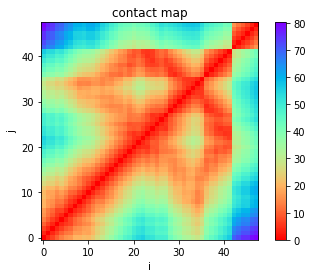

In [14]:
print(ct)

plt.title('contact map')
plt.imshow(ct[0],cmap='rainbow_r',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()
tools.hide_toggle()

## Now we want to use Expectation Reflection to infer the "calculate the weights " 
  * Infer interactions between residues (R-part of ammino acid) in proteins from Multiple Sequence Alignment (MSA) data
  * More understanding required on meaning/interpretation of weights
  
1. We can start by defining some important values of our protein structures
    * It is important to define 'i1i2' vector to keep track of OneHot index positions (i) coresonding to the beginning and end of a given amino acid position (this acts as a key between the OneHot matrix (s) and the original sequence matrix (s0)

In [15]:
# number of positions
n_var = s0.shape[1]
print("Number of residue positions:",n_var)

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])
print("Number of different amino acids at each position",mx)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 
print("(Sanity Check) Column indices of first and (",i1i2[0],") and last (",i1i2[-1],") positions")
print("(Sanity Check) Column indices of second and (",i1i2[1],") and second to last (",i1i2[-2],") positions")


# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var

Number of residue positions: 92
Number of different amino acids at each position [13 15 12 12 17 10 17  7 18 11 15  7 10  7  7 14 15 11 11  5 13  5 18 11
 15 12 12 18  4 16  4 15  9 14 18 17 17 18 19 18 16 20 18 21 19 19 20 12
 17 20 21 15 19  9 18 12 16  9 18  5  8 19 17 11 14 20 16 14  9 15  6 15
 16 15 10 13 18  4 18  9 15 12 18 18 16 16 17 16 12 17  4 12]
(Sanity Check) Column indices of first and ( [ 0 13] ) and last ( [1259 1271] ) positions
(Sanity Check) Column indices of second and ( [13 28] ) and second to last ( [1255 1259] ) positions
Total number of variables 1271


2.  The above indices help to divide all the possible amino acids at different positions to binary choices which will be implemented wit 1 of K notation (OneHot Encoder)

In [16]:
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
# s is OneHot encoder format, s0 is original sequnce matrix
s = onehot_encoder.fit_transform(s0)
print("Amino Acid sequence Matrix\n",s0)
print("OneHot sequence Matrix\n",s)
print("An individual element of the OneHot sequence Matrix (size:",
      s.shape,") --> ",s[0], " has length ",s[0].shape)

Amino Acid sequence Matrix
 [[ 9  3  8 ... 16  7 12]
 [ 3  8  3 ... 16  7 16]
 [ 3  9  2 ...  0  7 11]
 ...
 [ 8 17  2 ...  8  7  2]
 [17 11 14 ...  7  7  3]
 [ 6  5  2 ... 14  7 12]]
OneHot sequence Matrix
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
An individual element of the OneHot sequence Matrix (size: (18987, 1271) ) -->  [0. 0. 0. ... 0. 0. 0.]  has length  (1271,)


#### OneHot Format example
* Given 3 sequence poitions each with 3 different amino acids:
    * Notation: The 3<sup>rd</sup> amino acid type at the 2<sup>nd</sup> sequence position is denoted as R23<br/>
* OneHot converts the sequence [R11 R22 R33] &rightarrow; [1 0 0 0 1 0 0 0 1]  
  
  
3. We next want to define our local field parameters

In [17]:
# Define wight matrix with variable for each possible amino acid at each sequence position
w = np.zeros((mx.sum(),mx.sum())) 
h0 = np.zeros(mx.sum())

### Apply Expectation Reflection
4. We can now apply expectation reflection to infer the connection between postion residues

In [21]:
import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

In [22]:
# Expectation Reflection
#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1

#-------------------------------
# parallel
start_time = timeit.default_timer()
#res = Parallel(n_jobs = 4)(delayed(predict_w)\
res = Parallel(n_jobs = 8)(delayed(predict_w)\
#res = Parallel(n_jobs = 32)(delayed(predict_w)\
        (s,i0,i1i2,niter_max=10,l2=100.0)\
        for i0 in range(n_var))

run_time = timeit.default_timer() - start_time
print('run time:',run_time)
## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
## python implementation or just wrong
#----------------niter_max,l2)

#-------------------------------
# parallel
start_time = timeit.default_timer()
#res = Parallel(n_jobs = 4)(delayed(predict_w)\
#res = Parallel(n_jobs = 8)(delayed(predict_w)\
res = Parallel(n_jobs = 32)(delayed(predict_w)\
        (s,i0,i1i2,niter_max=10,l2=100.0)\
        for i0 in range(n_var))

run_time = timeit.default_timer() - start_time
print('run time:',run_time)
## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
## python implementation or just wrong
#-------------------------------
for i0 in range(n_var):
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    h01 = res[i0][0]
    w1 = res[i0][1]

    h0[i1:i2] = h01
    w[:i1,i1:i2] = w1[:i1,:]
    w[i2:,i1:i2] = w1[i1:,:]

# make w symmetric
w = (w + w.T)/2.



run time: 573.947786404
run time: 395.08040155100025


5. Now we want to plot a heat map of our sequence weights

In [23]:
# Verify that w is symmetric (sanity test)
print("Dimensions of w: ",w.shape)

Dimensions of w:  (1271, 1271)


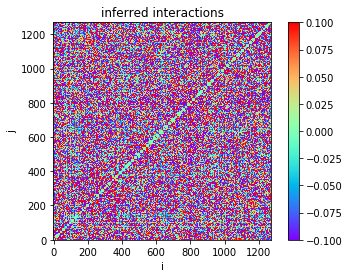

In [24]:
plt.title('inferred interactions')
plt.imshow(w,cmap='rainbow',origin='lower')
plt.clim(-0.1,0.1)
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)
tools.hide_toggle()

6. Plot relationship between sequence positions via Direct information

In [25]:
di = direct_info(s0,w)

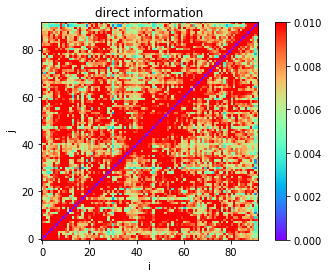

In [26]:
plt.title('direct information')
plt.imshow(di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)

# Plotting ER and DCA
### Plot ER

In [28]:
# find optimal threshold of distance
ct_thres = np.linspace(1.5,10.,18,endpoint=True)
n = ct_thres.shape[0]
ct_mat = ct[0]

auc = np.zeros(n)
for i in range(n):
    p,tp,fp = tools.roc_curve(ct_mat, di, ct_thres[i])
    auc[i] = tp.sum()/tp.shape[0]

#np.savetxt('auc.dat',(ct_thres,auc),fmt='%f')    

#>
# plot at optimal threshold:
i0 = np.argmax(auc)
print('auc max:',ct_thres[i0],auc[i0])
p0,tp0,fp0 = tools.roc_curve(ct_mat,di,ct_thres[i0])

iplot = [1,3,5,7,9,11,13]
plt.figure(figsize=(9.0,3.2))

plt.subplot2grid((1,4),(0,0))
plt.title('ROC various thres')
plt.plot([0,1],[0,1],'k--')
for i in iplot:
    p,tp,fp = tools.roc_curve(ct_mat,di,ct_thres[i])
    plt.plot(fp,tp,label='thres = %s'%ct_thres[i])

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot2grid((1,4),(0,1))
plt.title('ROC at thres = %3.2f'%(ct_thres[i0]))
plt.plot(fp0,tp0,'r-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot2grid((1,4),(0,2))
plt.title('AUC max = %f' %(auc[i0]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc,'r-')
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,auc.max()+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')

plt.subplot2grid((1,4),(0,3))
plt.title('Precision-Recall Curve')
for i in iplot:
    p,tp,fp = tools.roc_curve(ct_mat,di,ct_thres[i])
    plt.plot( p,tp / (tp + fp),label='thres = %s'%ct_thres[i])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')

plt.tight_layout(h_pad=1, w_pad=1.5)


tools.hide_toggle()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 48 but corresponding boolean dimension is 92

In [ ]:
#print("Direct Information from Expectation reflection:\n",di)
ER_di = di
#print(ER_di.shape)
#print("Direct Information from Expectation reflection:\n",di)

### Now we want to generate DI from original DCA method for comparison
* Want to compare AUC
* Want to compare using figure S6 (#sequences required)

In [ ]:
from inference_dca import direct_info_dca
DCA_di = direct_info_dca(s0)

### Plot DCA 

In [ ]:
# find optimal threshold of distance
ct_thres = np.linspace(1.5,10.,18,endpoint=True)
n = ct_thres.shape[0]

auc = np.zeros(n)
for i in range(n):
    p,tp,fp = tools.roc_curve(ct,DCA_di,ct_thres[i])
    auc[i] = tp.sum()/tp.shape[0]

#np.savetxt('auc.dat',(ct_thres,auc),fmt='%f')    

#>
# plot at optimal threshold:
i0 = np.argmax(auc)
print('auc max:',ct_thres[i0],auc[i0])
p0,tp0,fp0 = tools.roc_curve(ct,DCA_di,ct_thres[i0])

iplot = [1,3,5,7,9,11,13]
plt.figure(figsize=(9.0,3.2))

plt.subplot2grid((1,4),(0,0))
plt.title('ROC various thres')
plt.plot([0,1],[0,1],'k--')
for i in iplot:
    p,tp,fp = tools.roc_curve(ct,DCA_di,ct_thres[i])
    plt.plot(fp,tp,label='thres = %s'%ct_thres[i])

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot2grid((1,4),(0,1))
plt.title('ROC at thres = %3.2f'%(ct_thres[i0]))
plt.plot(fp0,tp0,'r-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot2grid((1,4),(0,2))
plt.title('AUC max = %f' %(auc[i0]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc,'r-')
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,auc.max()+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')

plt.subplot2grid((1,4),(0,3))
plt.title('Precision-Recall Curve')
for i in iplot:
    p,tp,fp = tools.roc_curve(ct,di,ct_thres[i])
    plt.plot( p,tp / (tp + fp),label='thres = %s'%ct_thres[i])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')

plt.tight_layout(h_pad=1, w_pad=1.5)

tools.hide_toggle()

## Compare Optimal DCA and ER (ct_thresh = 1.5 and 2. resp.)
* Taking the optimal threshold for each gives comparable accuracy
* ER Has higher accuracy for lower threshold

In [ ]:
# find optimal threshold of distance for both DCA and ER
ct_thres = np.linspace(1.5,10.,18,endpoint=True)
n = ct_thres.shape[0]

auc_DCA = np.zeros(n)
auc_ER = np.zeros(n)
for i in range(n):
    p,tp,fp = tools.roc_curve(ct,DCA_di,ct_thres[i])
    auc_DCA[i] = tp.sum()/tp.shape[0]
    
    p,tp,fp = tools.roc_curve(ct,ER_di,ct_thres[i])
    auc_ER[i] = tp.sum()/tp.shape[0]
    
i0_DCA = np.argmax(auc_DCA)
i0_ER = np.argmax(auc_ER)

print('DCA auc max:',ct_thres[i0_DCA],auc[i0_DCA])
p0_DCA,tp0_DCA,fp0_DCA = tools.roc_curve(ct,DCA_di,ct_thres[i0_DCA])
print('ER auc max:',ct_thres[i0_ER],auc[i0_ER])
p0_ER,tp0_ER,fp0_ER = tools.roc_curve(ct,ER_di,ct_thres[i0_ER])

tools.hide_toggle()

In [ ]:
# Plot ROC for optimal DCA vs optimal ER
plt.subplot2grid((1,3),(0,0))
plt.title('ROC at thres (DCA, ER)\n = (%3.2f, %3.2f)'%(ct_thres[i0_DCA],ct_thres[i0_ER]))
plt.plot(fp0_ER,tp0_ER,'b-',label="ER")
plt.plot(fp0_DCA,tp0_DCA,'r-',label="DCA")
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Plot AUC for DCA and ER
plt.subplot2grid((1,3),(0,1))
plt.title('AUC (DCA, ER) max\n = (%3.2f, %3.2f)' %(auc_DCA[i0_DCA], auc_ER[i0_ER]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_DCA,'b-',label="DCA")
plt.plot(ct_thres,auc_ER,'r-',label="ER")
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,auc.max()+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')
plt.legend()

# Plot Precision of optimal DCA and ER
plt.subplot2grid((1,3),(0,2))
plt.title('Precision at thres \n(DCA, ER) = (%3.2f, %3.2f)'%(ct_thres[i0_DCA],ct_thres[i0_ER]))
plt.plot( p0_DCA,tp0_DCA / (tp0_DCA + fp0_DCA),'r-',label='DCA thres = %s'%ct_thres[i0_DCA])
plt.plot( p0_ER,tp0_ER / (tp0_ER + fp0_ER),'b-',label='ER thres = %s'%ct_thres[i0_ER])
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')
plt.legend()

plt.tight_layout(h_pad=1, w_pad=1.5)


tools.hide_toggle()